# King County House Prices

## Modules

In [358]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import probscale

import statsmodels.formula.api as smf
from sklearn import model_selection

## Data set

In [359]:
df = pd.read_csv('kc_house_prices/King_County_House_prices_dataset.csv')

In [360]:
print(df.info())
print()
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The id is an artificial label for each individual house. It can be dropped.

In [361]:
df.drop('id', axis=1, inplace=True)
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Task: Model the house price.

Question behind:
- build a price calculator for a local realtor
- build a price calculator for private sellers
- build a house finder for home buyers
- counsel investors what and where to buy


# Removing outliers

We want to focus on ordinary properties and therefore remove sales above some price and property size cutoff. Where to put those cutoffs? 


## Price cutoff

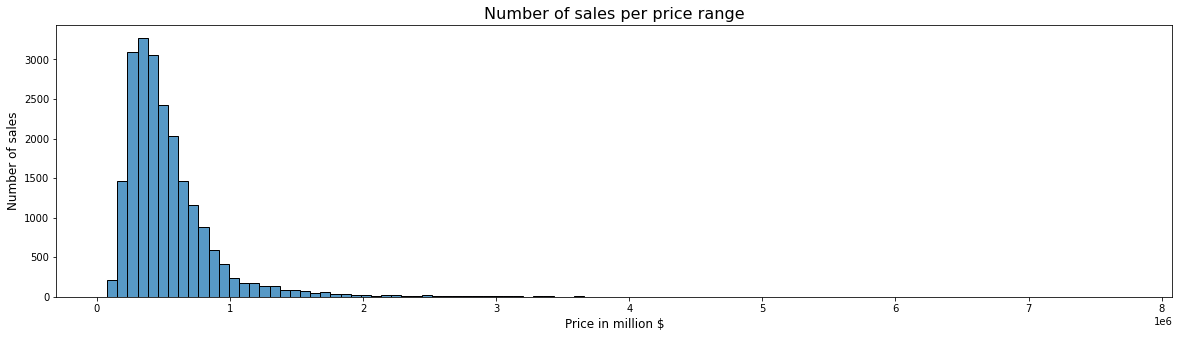

In [362]:
fig = plt.figure(figsize=(20,5))
sns.histplot(df.price, bins=100)
plt.xlabel('Price in million $', fontsize=12)
plt.ylabel('Number of sales', fontsize=12)
plt.title('Number of sales per price range', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/cutoff_price.png', format='png', dpi=150)

It seems reasonable to cut off at 2 or 3 millions. How many sales would be dropped in either case?

In [363]:
print('2 millions:', len(df.query('price > 2000001')))
print('3 millions:', len(df.query('price > 3000001')))

2 millions: 198
3 millions: 45


Do the sales between 2 and 3 millions follow a pattern?

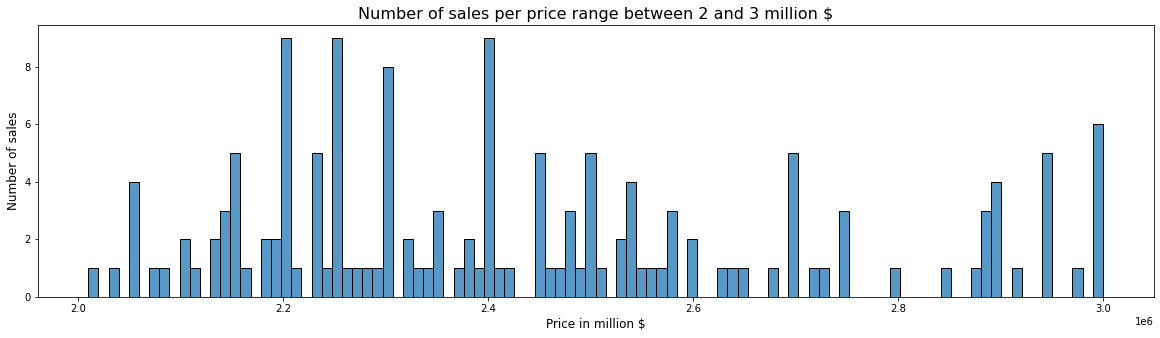

In [364]:
plt.figure(figsize=(20,5))
sns.histplot(df.query('2000000 < price < 3000001').price, bins=100)
plt.xlabel('Price in million $', fontsize=12)
plt.ylabel('Number of sales', fontsize=12)
plt.title('Number of sales per price range between 2 and 3 million $', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/cutoff_price_2_3.png', format='png', dpi=150)

This seems rather random. So, we cut off at 2 millions.

In [365]:
df = df.query('price < 2000001')

## Property Size Cutoff

Property size is measured by `sqft_living`and `sqft_lot`. We proceed by analogy but use scatter plots of price vs these variables.

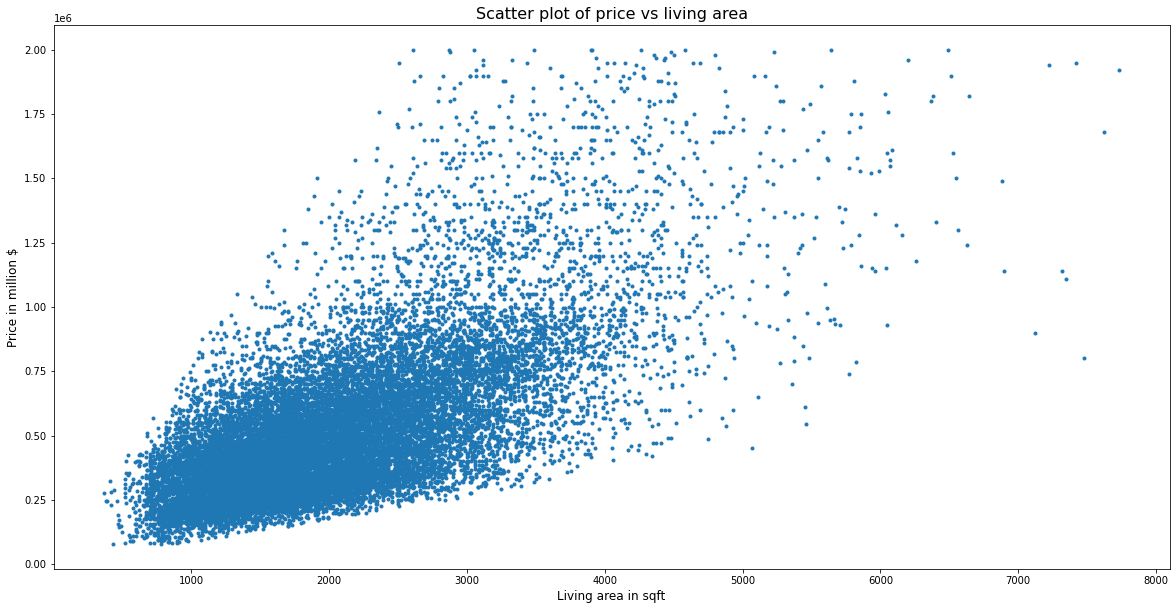

In [366]:
plt.figure(figsize=(20,10))
plt.scatter(x=df.sqft_living, y=df.price, marker='.')
plt.xlabel('Living area in sqft', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Scatter plot of price vs living area', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/cutoff_sqft_living.png', format='png', dpi=150);

It seems reasonable to cut off at 6500 sqft. How many sales do we lose this way?

In [367]:
len(df.query('sqft_living > 6500'))

16

This is alright. Let us drop them.

In [368]:
df = df.query('sqft_living < 6501')

Now, consider `sqft_lot`. 

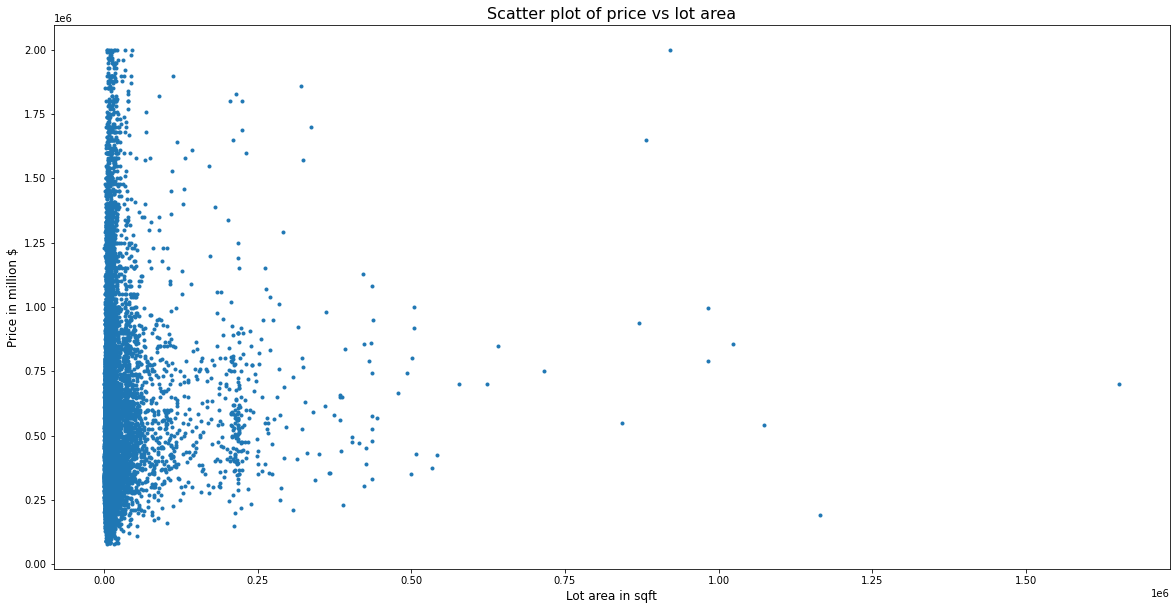

In [369]:
plt.figure(figsize=(20,10))
plt.scatter(x=df.sqft_lot, y=df.price, marker='.')
plt.xlabel('Lot area in sqft', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Scatter plot of price vs lot area', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/cutoff_sqft_lot.png', format='png', dpi=150);

We may cut off at, say, 600,000. How many will be lost then?

In [370]:
len(df.query('sqft_lot > 600000'))

13

Alright, let's do it.

In [371]:
df = df.query('sqft_lot < 600001')

# Variables

Separate the variables into the 4 groups status, location, time, size

In [372]:
vars_stat = ['view', 'waterfront', 'condition', 'grade']
vars_loc = ['zipcode', 'lat', 'long']
vars_time = ['date', 'yr_built', 'yr_renovated']
vars_size = ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
            'sqft_living15', 'sqft_lot15']

## Status variables

In [373]:
for var in vars_stat:
    print(var+':', sorted(df[var].unique()))

view: [0.0, nan, 1.0, 2.0, 3.0, 4.0]
waterfront: [nan, 0.0, 1.0]
condition: [1, 2, 3, 4, 5]
grade: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


We replace `nan` by -1 for better handling but keep in mind that the numerical value -1 has no meaning.

In [374]:
df.view = df.view.replace({x:x if x > -1 else -1 for x in df.view})
df.waterfront = df.waterfront.replace({x:x if x > -1 else -1 for x in df.waterfront})

How do the basic statistical scores of house prices depend on the status variables?
(The violin plots below may extend above our cutoff, because they show an estimated probability density function.)

#### Violin plots:

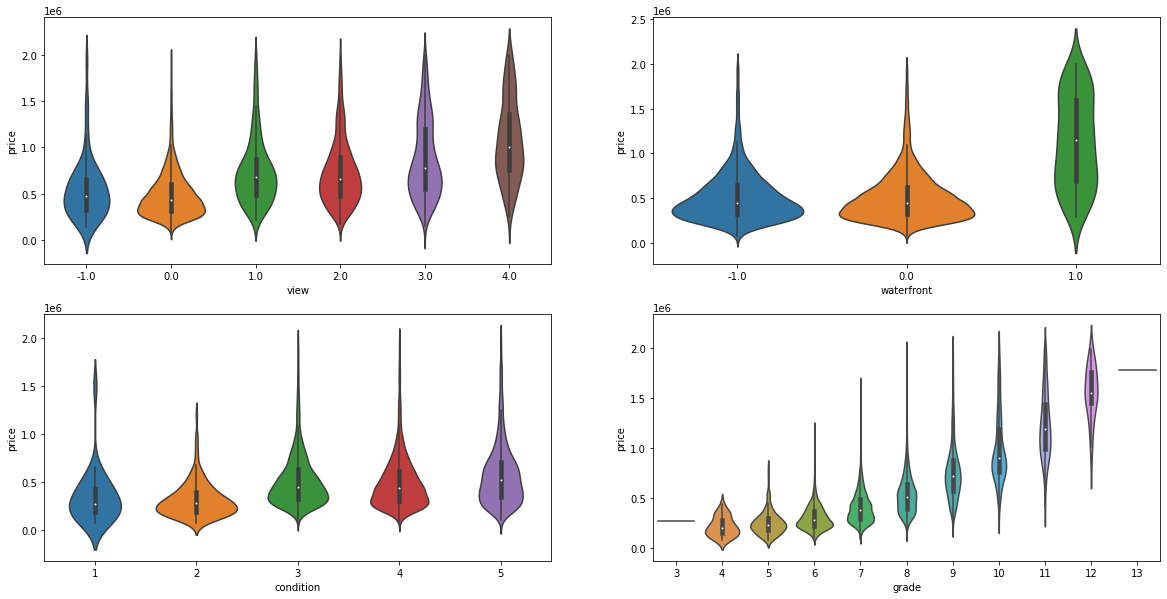

In [375]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.violinplot(ax=ax[0][0], x=df.view, y=df.price)
sns.violinplot(ax=ax[0][1], x=df.waterfront, y=df.price)
sns.violinplot(ax=ax[1][0], x=df.condition, y=df.price)
sns.violinplot(ax=ax[1][1], x=df.grade, y=df.price)
fig.show;
#plt.savefig('images/var_cat_vio.png', format='png', dpi=150);

#### Line plots:

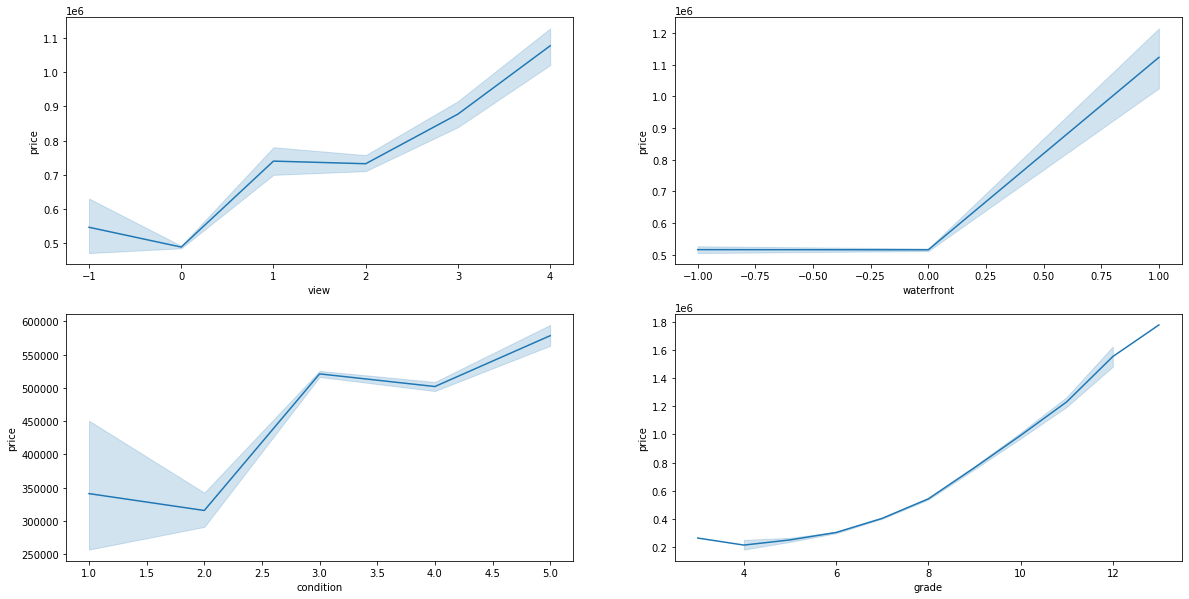

In [376]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.lineplot(ax=ax[0][0], x=df.view, y=df.price)
sns.lineplot(ax=ax[0][1], x=df.waterfront, y=df.price)
sns.lineplot(ax=ax[1][0], x=df.condition, y=df.price)
sns.lineplot(ax=ax[1][1], x=df.grade, y=df.price)
fig.show;
#plt.savefig('images/var_cat_lin.png', format='png', dpi=150);

How many sales per value are there?

In [377]:
print('view:', [(val, df.view.value_counts()[val]) for val in sorted(df.view.unique())])
print('waterfront:', [(val, df.waterfront.value_counts()[val]) for val in sorted(df.waterfront.unique())])
print('condition:', [(val, df.condition.value_counts()[val]) for val in sorted(df.condition.unique())])
print('grade:', [(val, df.grade.value_counts()[val]) for val in sorted(df.grade.unique())])

view: [(-1.0, 62), (0.0, 19335), (1.0, 317), (2.0, 928), (3.0, 477), (4.0, 251)]
waterfront: [(-1.0, 2358), (0.0, 18909), (1.0, 103)]
condition: [(1, 29), (2, 168), (3, 13878), (4, 5625), (5, 1670)]
grade: [(3, 1), (4, 27), (5, 241), (6, 2037), (7, 8972), (8, 6057), (9, 2594), (10, 1071), (11, 320), (12, 49), (13, 1)]


All four status variables have a decent influence on price, so a priorily we should include them into our model. Has an influence, so we should include it in our model. 

Let us further clean the dataset. Since the sales with view = `nan` strongly vary in price and since there are only few of them, we remove them from the dataset. Similarly for the sales with condition = 1. Since grades 3 and 13 have only one sale each, we remove them as well. 

What to do with the sales with waterfront = `nan`? They represent > 10% of the dataset. According to the violin plots one could suppose that their prices behave like the non-waterfront ones, but this could be misleading, as the number of waterfront properties is so small that the `nan` part could contain waterfront properties at the same ratio as the rest of the dataset as well, without visibly deforming the violin plot. Anyway, it seems much better to include them into the non-waterfront part than to drop them. Later on, we may also follow the alternative strategy and then compare results.

In [378]:
df = df.query('view > -1 and grade > 3 and grade < 13 and condition > 1')
#df = df.replace({x:0 if x == -1 else x for x in df.waterfront})

Plots for the cleaned dataset:

#### Violin plots:

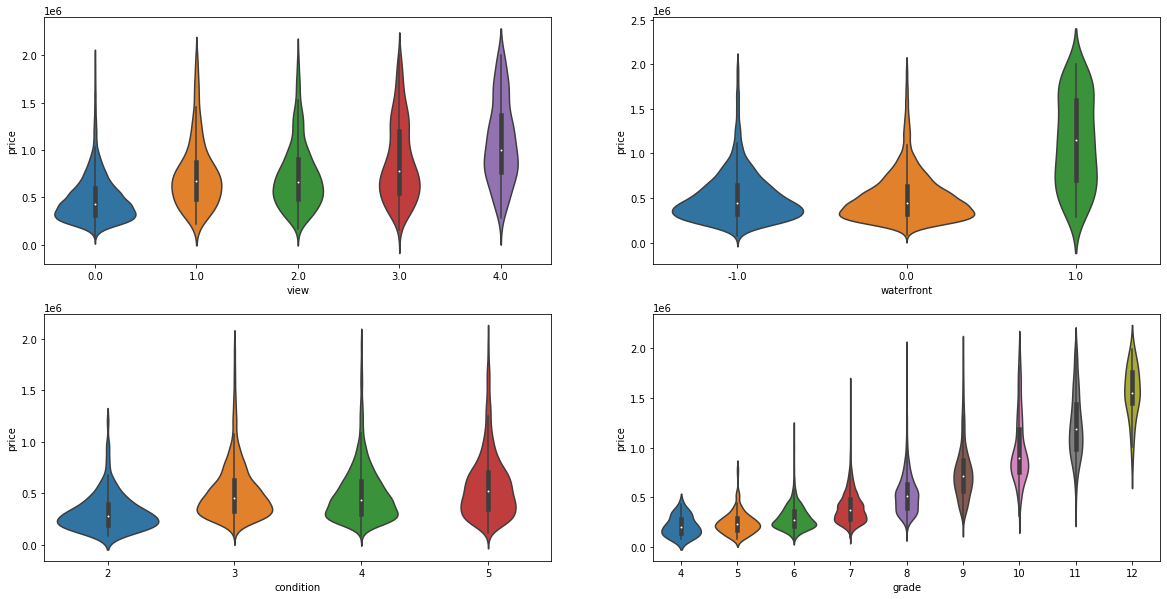

In [379]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.violinplot(ax=ax[0][0], x=df.view, y=df.price)
sns.violinplot(ax=ax[0][1], x=df.waterfront, y=df.price)
sns.violinplot(ax=ax[1][0], x=df.condition, y=df.price)
sns.violinplot(ax=ax[1][1], x=df.grade, y=df.price)
fig.show;
#plt.savefig('images/var_cat_vio_cleaned.png', format='png', dpi=150);

#### Line plots

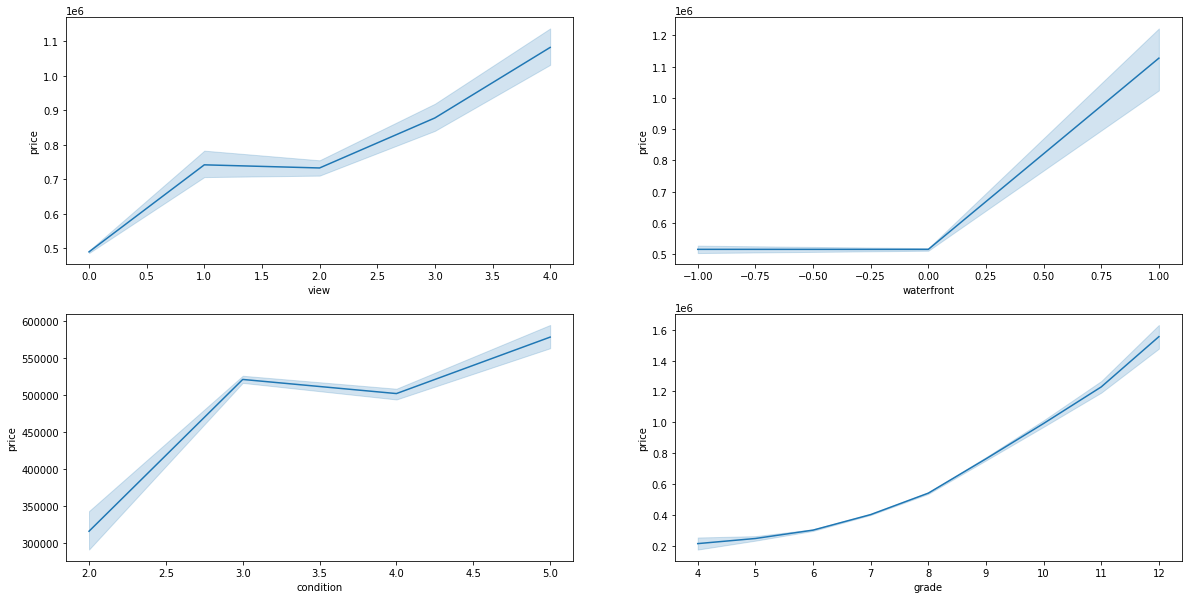

In [380]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.lineplot(ax=ax[0][0], x=df.view, y=df.price)
sns.lineplot(ax=ax[0][1], x=df.waterfront, y=df.price)
sns.lineplot(ax=ax[1][0], x=df.condition, y=df.price)
sns.lineplot(ax=ax[1][1], x=df.grade, y=df.price)
fig.show;
#plt.savefig('images/var_cat_lin_cleaned.png', format='png', dpi=150);

Waterfront is now alright. However, for the remaining 3 status variables, linear approximation does not seem to be preferable. Therefore, we introduce dummy variables for each of them.

In [381]:
dum_view = pd.get_dummies(df.view, drop_first=True, prefix='view')
dum_waterfront = pd.get_dummies(df.waterfront, drop_first=True, prefix='waterfront')
dum_condition = pd.get_dummies(df.condition, drop_first=True, prefix='condition')
dum_grade = pd.get_dummies(df.grade, drop_first=True, prefix='grade')

if 'view_1' not in df.columns:
    df = pd.concat([df, dum_view, dum_waterfront, dum_condition, dum_grade], axis=1)
    df.columns = [col.replace('.0', '') for col in df.columns]
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'view_1', 'view_2', 'view_3', 'view_4',
       'waterfront_0', 'waterfront_1', 'condition_3', 'condition_4',
       'condition_5', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12'],
      dtype='object')

In [382]:
vars_stat = ['view_1', 'view_2', 'view_3', 'view_4', 
             'waterfront_0', 'waterfront_1',
             'condition_3', 'condition_4', 'condition_5', 
             'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12']

## Location variables

In [383]:
for var in vars_loc:
    print(var+':', df[var].min(), df[var].max(), df[var].nunique())

zipcode: 98001 98199 70
lat: 47.1559 47.7776 5025
long: -122.519 -121.315 748


Location certainly has an influence on price. Both zipcode and coordinate (long-lat) pair label location, so there should be a relation between either one and price. The relation is certainly not monotonous though. Long-lat coordinate pairs yield a finer resolution than zipcode, but the resolution by zipcode might be sufficient.

Ranges of sales for fixed zipcode:

In [384]:
df.zipcode.value_counts().min(), df.zipcode.value_counts().max()

(29, 600)

Violin plots of price vs zipcode:

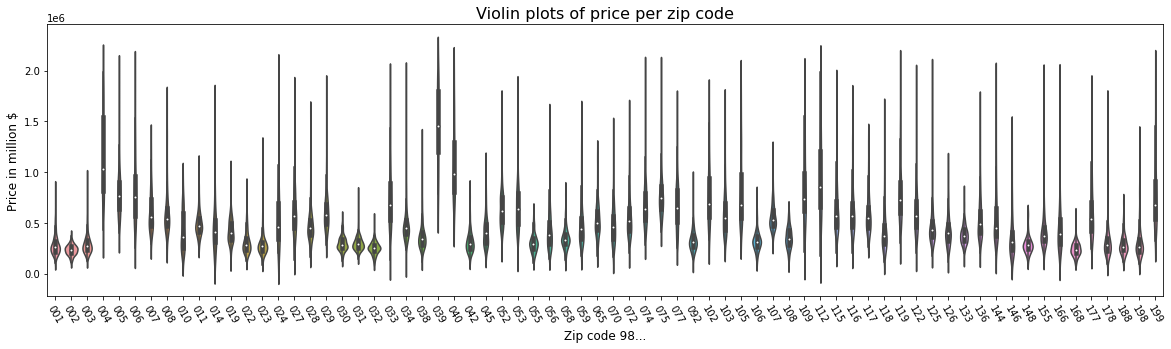

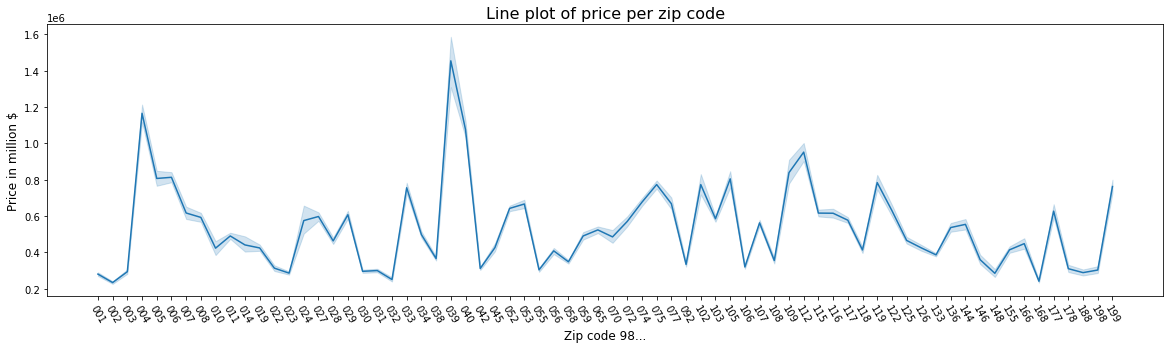

In [385]:
D = pd.DataFrame(df.price)
D['zipcode'] = df.zipcode.replace({x:str(x)[2:5] for x in df.zipcode})
D = D.sort_values('zipcode')

fig = plt.figure(figsize=(20,5))
sns.violinplot(x=D.zipcode, y=D.price, xticklabels='')
plt.xlabel('Zip code 98...', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per zip code', fontsize=16)
plt.xticks(rotation=-60, fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_loc_zip_vio.png', format='png', dpi=150)

plt.figure(figsize=(20,5))
sns.lineplot(x=D.zipcode, y=D.price);
plt.xlabel('Zip code 98...', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Line plot of price per zip code', fontsize=16)
plt.xticks(rotation=-60, fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_loc_zip_lin.png', format='png', dpi=150)

The mean prices vary significantly compared to their confidence intervals, so we should include them in the variables of our model. To do so, it seems reasonable to assign a location score to each zip code. We choose the median of the price of a square foot of living area.

In [386]:
D = pd.DataFrame(df[['price', 'zipcode', 'sqft_living']])
D['price_per_sqft'] = D.eval('price / sqft_living')
loc_score_map = dict([(z, round(D.query(f'zipcode == {z}').price_per_sqft.median(), 2)) for z in D.zipcode.unique()])
df['loc_score'] = df.zipcode.replace(loc_score_map)

We have the following scores.

In [387]:
print([x for x in sorted(df.loc_score.unique())])

[144.88, 146.2, 146.76, 147.18, 149.18, 152.17, 154.82, 157.07, 159.27, 163.9, 165.14, 165.45, 170.79, 171.95, 173.04, 173.9, 176.62, 181.42, 194.21, 196.72, 197.25, 201.31, 204.63, 206.34, 208.3, 208.63, 209.53, 210.41, 215.5, 221.1, 222.46, 234.9, 241.7, 241.97, 242.33, 243.2, 244.93, 250.51, 250.58, 251.44, 254.86, 255.21, 263.98, 267.46, 270.44, 271.41, 274.27, 274.63, 286.41, 289.09, 289.59, 301.02, 316.46, 318.46, 321.23, 335.85, 336.84, 344.21, 353.66, 355.08, 361.06, 370.37, 372.36, 387.82, 405.11, 410.05, 417.11, 425.27, 444.72, 525.42]


One might use long-lat pairs to get a finer resolution of location and see whether this improves the predictivity of the model. In addition, one might study how the area score (relative to zipcode or a refinement) varies with the date of sale. For now, we skip any further analysis of the location variables. 

So, for now, we keep a single location variable:

In [388]:
vars_loc = ['loc_score']

Alternatively, we may add a dummy variable for every zipcode. In that case, it is easier to keep only the variables entering lin reg and drop all the others. This will be done after the discussion of variables.

## Time variables

Ranges of the values for the year the house was built and the year it was last renovated:

In [389]:
print('yr_built:', df['yr_built'].min(), df['yr_built'].max(), df['yr_built'].nunique())
print('yr_renovated:', df['yr_renovated'].min(), df['yr_renovated'].max(), df['yr_renovated'].nunique())
len(df)

yr_built: 1900 2015 116
yr_renovated: 0.0 2015.0 70


21277

A value of 0.0 or NaN for yr_renovated certainly means that the house has never been renovated. Therefore, we replace NaN and values < yr_built by yr_built:

In [390]:
df.yr_renovated = df.yr_renovated.replace({row.yr_renovated:int(max(row.yr_renovated, row.yr_built)) 
                                           if row.yr_renovated > -1 
                                           else row.yr_built 
                                           for ctr, row in df.T.iteritems()})

Sales dates should be turned into datetime objects first:

In [391]:
df.date = pd.to_datetime(df.date)

Earliest and latest date:

In [392]:
df.date.min(), df.date.max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

It seems reasonable to replace date by the numnber of months passed between May 2014 and the date of sale.  

In [393]:
df['time'] = df.date.replace({d:(int(str(d)[5:7]) - 5) % 12 for d in df.date})

Violin plots:

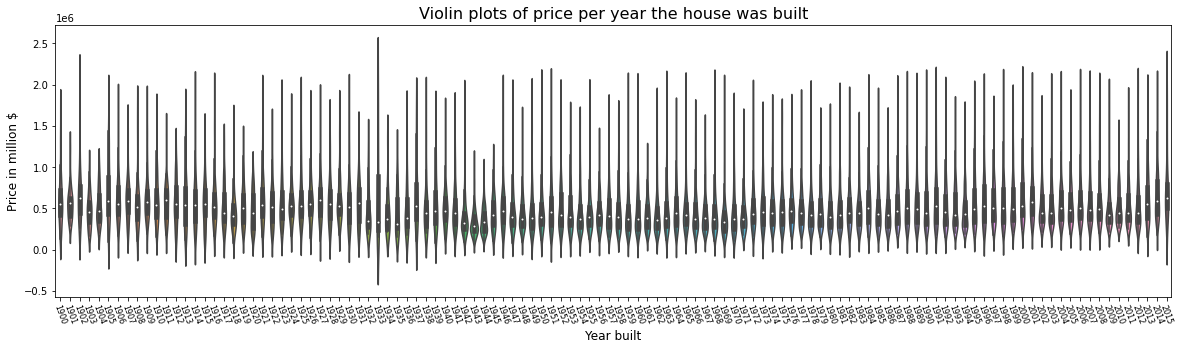

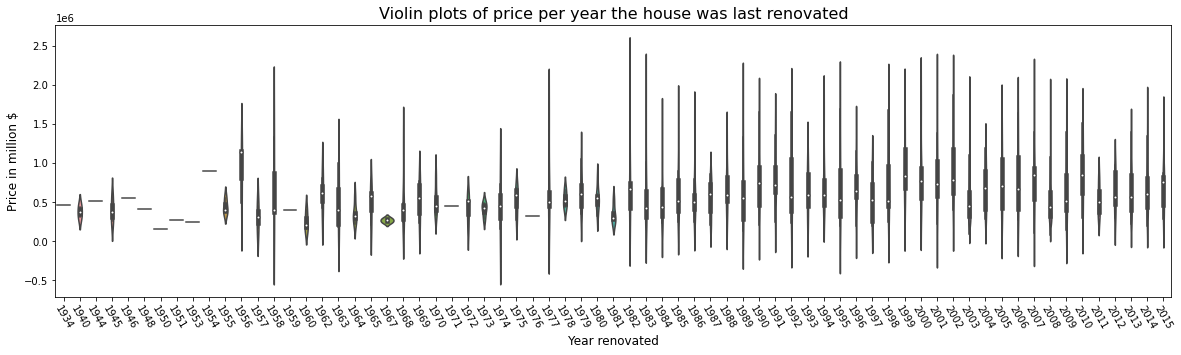

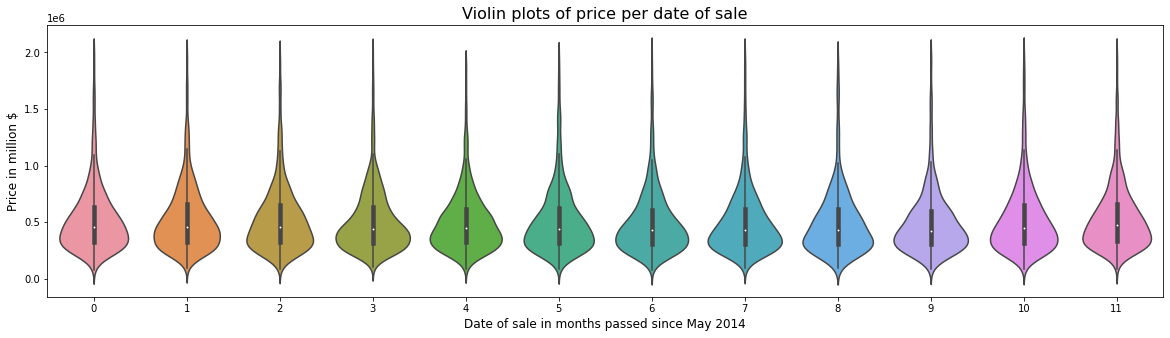

In [394]:
D = pd.DataFrame(df.price)
D['yr_built'] = df.yr_built.replace({x:str(x)[:4] for x in df.yr_built})    
D = D.sort_values('yr_built')
    
fig = plt.figure(figsize=(20,5))
sns.violinplot(x=D.yr_built, y=D.price)
plt.xlabel('Year built', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per year the house was built', fontsize=16)
plt.xticks(rotation=-70, fontsize=8)
plt.yticks(fontsize=10);
#plt.savefig('images/var_tim_yr_built_vio.png', format='png', dpi=150);

D = pd.DataFrame(df.price)
D['yr_renovated'] = df.yr_renovated.replace({x:str(x)[:4] for x in df.yr_renovated}) 
D = D.sort_values('yr_renovated')

fig = plt.figure(figsize=(20,5))
sns.violinplot(x=D.yr_renovated, y=D.price)
plt.xlabel('Year renovated', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per year the house was last renovated', fontsize=16)
plt.xticks(rotation=-60, fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_tim_yr_renovated_vio.png', format='png', dpi=150);

fig = plt.figure(figsize=(20,5))
sns.violinplot(x=df.time, y=df.price)
plt.xlabel('Date of sale in months passed since May 2014', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per date of sale', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_tim_date_vio.png', format='png', dpi=150);

At first glance, none of the time variables seems to have a significant influence on price, but for now we can keep all three in our set of variables:

In [395]:
vars_time = ['time', 'yr_built', 'yr_renovated']

## Size variables

### Room numbers

The discrete size variables `bedrooms`, `bathrooms`and `floors` take the following values and frequencies:

In [396]:
print('bed rooms:', [(val, df.bedrooms.value_counts()[val]) for val in sorted(df.bedrooms.unique())])
print()
print('bath rooms:', [(val, df.bathrooms.value_counts()[val]) for val in sorted(df.bathrooms.unique())])
print()
print('floors:', [(val, df.floors.value_counts()[val]) for val in sorted(df.floors.unique())])

bed rooms: [(1, 191), (2, 2737), (3, 9749), (4, 6759), (5, 1532), (6, 256), (7, 31), (8, 11), (9, 6), (10, 3), (11, 1), (33, 1)]

bath rooms: [(0.5, 4), (0.75, 69), (1.0, 3820), (1.25, 9), (1.5, 1436), (1.75, 3032), (2.0, 1921), (2.25, 2030), (2.5, 5345), (2.75, 1181), (3.0, 735), (3.25, 549), (3.5, 708), (3.75, 141), (4.0, 115), (4.25, 56), (4.5, 87), (4.75, 10), (5.0, 16), (5.25, 9), (5.5, 1), (5.75, 1), (6.5, 1), (7.5, 1)]

floors: [(1.0, 10581), (1.5, 1884), (2.0, 8059), (2.5, 141), (3.0, 606), (3.5, 6)]


Violin plots:

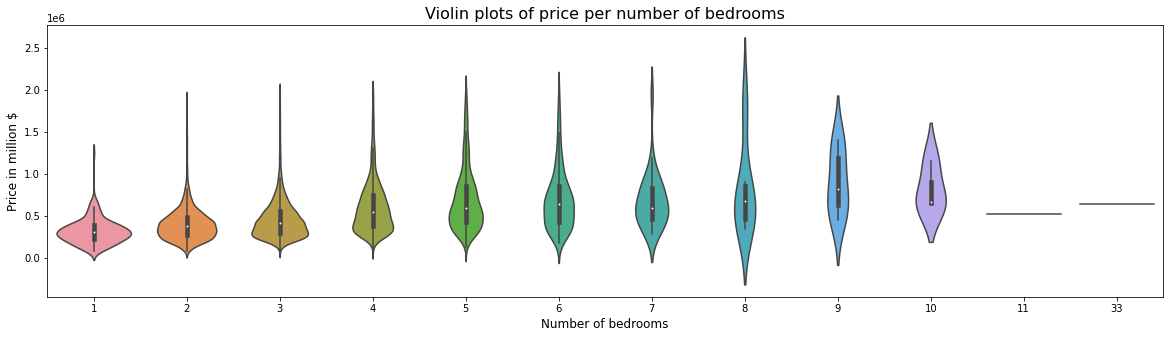

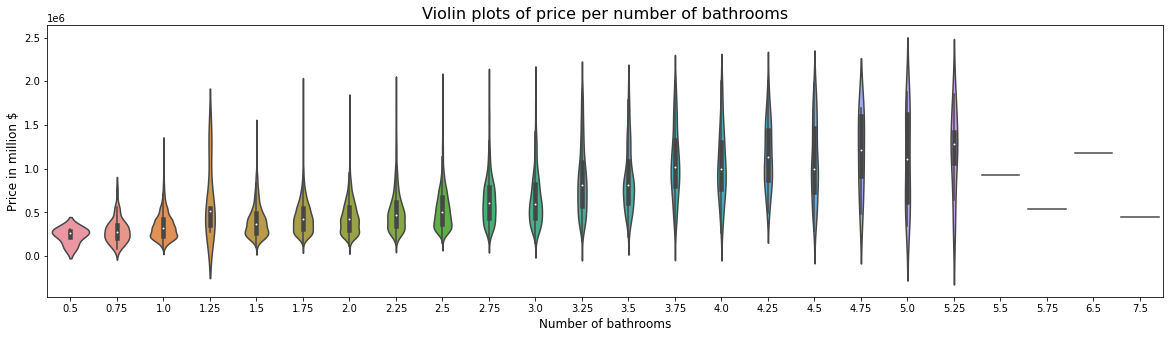

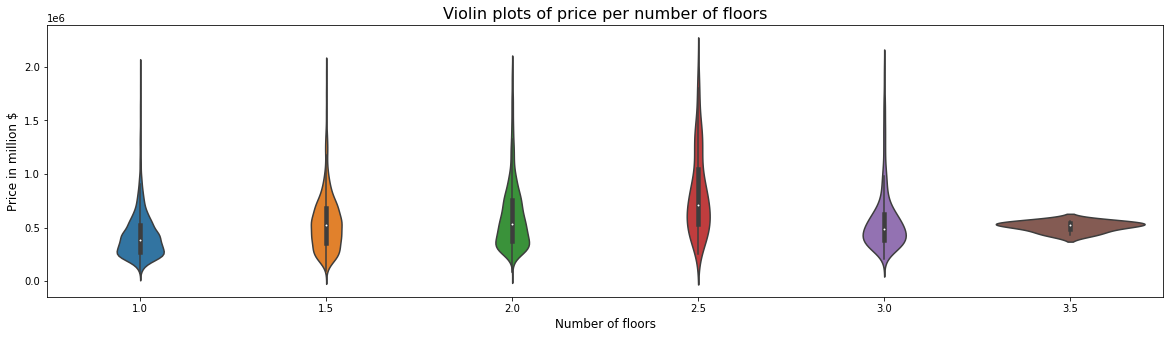

In [397]:
fig = plt.figure(figsize=(20,5))
sns.violinplot(x=df.bedrooms, y=df.price, marker='.')
plt.xlabel('Number of bedrooms', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per number of bedrooms', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_num_bedrooms_vio.png', format='png', dpi=150)

fig = plt.figure(figsize=(20,5))
sns.violinplot(x=df.bathrooms, y=df.price, marker='.')
plt.xlabel('Number of bathrooms', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per number of bathrooms', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_num_bathrooms_vio.png', format='png', dpi=150)

fig = plt.figure(figsize=(20,5))
sns.violinplot(x=df.floors, y=df.price, marker='.')
plt.xlabel('Number of floors', fontsize=12)
plt.ylabel('Price in million $', fontsize=12)
plt.title('Violin plots of price per number of floors', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);
#plt.savefig('images/var_num_floors_vio.png', format='png', dpi=150)

Expectedly, prices increase with increasing numbers of `bedrooms` and `bathrooms`. To clean the data, we remove the singular cases not fitting this trend:

In [398]:
df = df.query('bedrooms < 10 and bathrooms < 5')

For the number of floors, the relation has a maximum at 2,5 floors. It is less significant though. Anyway, we can drop sales of houses with more than 3 floors, as they are only 6 in number:

In [399]:
df = df.query('floors <=3')

### Area variables

All of the six area variables `sqft_...` can be expected to be significant. However, `sqft_living` should coincide with the sum of `sqft_basement`and `sqft_above`. Let us test this for the sales where values for both of the latter are given. A look at the values of `sqft_basement` shows that they are numerical strings except for 447 sales where no information was given, indicated by a `'?'`. For the numerical values, we find `sqft_living = sqft_basement + sqft_above`, indeed:

In [400]:
chk = pd.DataFrame(df.query('sqft_basement != "?"')[['sqft_living', 'sqft_above']])
chk['sqft_basement'] = df.query('sqft_basement != "?"').sqft_basement.replace({x:float(x) for x in df.query('sqft_basement != "?"').sqft_basement})
print(chk.eval('sqft_basement + sqft_above - sqft_living').value_counts())

0.0    20793
dtype: int64


Accordingly, for the missing values, we may put `sqft_basement = sqft_living - sqft_above`, as long as this gives a nonnegative result.

In [401]:
df.sqft_basement = df.eval('sqft_living - sqft_above')
df.sqft_basement.min()

0

As a result, we may trade the variable `sqft_living` for the two variables `sqft_basement` and `sqft_above`, because this might give more precision. After training, we should check whether the latter two variables happen to have the same slope. If so, we should replace them by `sqft_living`.

Finally, as `sqft...15` measure the mean area of neighbouring properties, let us check whether we would be better off with the differences or the ratios of `sqft_living` vs `sqft_living15` and `sqft_lot` vs `sqft_lot15`. For that purpose, we compare their correlation with price.

In [402]:
cols = ['sqft_living15', 'sqft_living - sqft_living15', 'sqft_living / sqft_living15', 'sqft_living15 / sqft_living', 
        'sqft_lot15', 'sqft_lot - sqft_lot15', 'sqft_lot / sqft_lot15', 'sqft_lot15 / sqft_lot']

chk = pd.DataFrame(df.price)

for col in cols:
    colname = col.replace(' - ','_minus_').replace(' / ','_by_')
    chk[colname] = df.eval(col)
    
print('Correlation of')

for col in chk.columns[1:]:
    print('price with '+col+': ', smf.ols(formula='price ~ '+col, data=chk).fit().rsquared)

Correlation of
price with sqft_living15:  0.3581803293239959
price with sqft_living_minus_sqft_living15:  0.09793969544023451
price with sqft_living_by_sqft_living15:  0.07176086470226495
price with sqft_living15_by_sqft_living:  0.05934813492589397
price with sqft_lot15:  0.005937431077921107
price with sqft_lot_minus_sqft_lot15:  0.0027447102309509086
price with sqft_lot_by_sqft_lot15:  0.0019301562276781148
price with sqft_lot15_by_sqft_lot:  0.002012357784582197


As a result, it seems that we are better off with the absolute values of `sqft_living15`and `sqft_lot15`. To conclude, our candidates for the size variables are

In [403]:
vars_size = ['bedrooms', 'bathrooms', 'floors', 'sqft_above', 'sqft_basement', 'sqft_lot', 'sqft_living15', 'sqft_lot15']

and thus the total set of variables is

In [404]:
vars = vars_stat + vars_loc + vars_time + vars_size
len(vars)

29

# Tuning

Linear regression for all variables:

In [405]:
smf.ols(formula = 'price ~ ' + ' + '.join(vars), data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3767.
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:34:51   Log-Likelihood:            -2.7761e+05
No. Observations:               21238   AIC:                         5.553e+05
Df Residuals:                   21208   BIC:                         5.555e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.712e+05      4e+05      0.678      0.498   -5.12e+05    1.05e+06
view_1         7.148e+04   6622.193     10.795      0.000    5.85e+04    8.45e+04
view_2         6.073e+04   3992.705     15.211      0.000    5.29e+04    6.86e+04
view_3         1.306e+05   5544.562     23.563      0.000     1.2e+05    1.42e+05
view_4         2.493e+05   8790.384     28.356      0.000    2.32e+05    2.66e+05
waterfront_0   -560.4756   2522.423     -0.222      0.824   -5504.616    4383.665
waterfront_1   3.006e+05   1.37e+04     22.012      0.000    2.74e+05    3.27e+05
condition_3    2.034e+04   9033.784      2.252      0.024    2637.922    3.81e+04
condition_4    4.383e+04   9072.785      4.831      0.000     2.6e+04    6.16e+04
condition_5    8.101e+04   9394.694      8.623      0.000    6.26e+04    9.94e+04
grade_5       -2.766e+04   2.38e+04     -1.160      0.246   -7.44e+04    1.91e+04
grade_6       -2.593e+04   2.28e+04     -1.138      0.255   -7.06e+04    1.87e+04
grade_7       -1.641e+04   2.27e+04     -0.721      0.471    -6.1e+04    2.82e+04
grade_8        1.614e+04   2.29e+04      0.706      0.480   -2.87e+04     6.1e+04
grade_9        1.029e+05   2.31e+04      4.458      0.000    5.77e+04    1.48e+05
grade_10       2.009e+05   2.34e+04      8.577      0.000    1.55e+05    2.47e+05
grade_11       3.148e+05   2.43e+04     12.938      0.000    2.67e+05    3.62e+05
grade_12       4.986e+05   2.91e+04     17.164      0.000    4.42e+05    5.56e+05
loc_score      1942.7846     12.455    155.983      0.000    1918.372    1967.198
time           2509.4064    216.912     11.569      0.000    2084.242    2934.571
yr_built       -274.6990     41.866     -6.561      0.000    -356.760    -192.638
yr_renovated    -51.2265    200.916     -0.255      0.799    -445.038     342.585
bedrooms      -2467.5703   1187.746     -2.078      0.038   -4795.642    -139.498
bathrooms      2.332e+04   1932.821     12.065      0.000    1.95e+04    2.71e+04
floors        -3.592e+04   2169.164    -16.559      0.000   -4.02e+04   -3.17e+04
sqft_above      135.4188      2.330     58.110      0.000     130.851     139.987
sqft_basement    81.2490      2.630     30.892      0.000      76.094      86.404
sqft_lot          0.3345      0.038      8.802      0.000       0.260       0.409
sqft_living15    37.3107      2.015     18.520      0.000      33.362      41.260
sqft_lot15       -0.1949      0.049     -3.949      0.000      -0.292      -0.098
==============================================================================
Omnibus:                     5844.834   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45566.490
Skew:                           1.108   Prob(JB):                         0.00
Kurtosis:                       9.825   Cond. No.            

Let us remove the variables with large P > |t| value, ie grade_5...8 and yr_renovated:

In [406]:
vars.remove('waterfront_0')
vars.remove('grade_5')
vars.remove('grade_6')
vars.remove('grade_7')
vars.remove('grade_8')
vars.remove('yr_renovated')

In [407]:
smf.ols(formula = 'price ~ ' + ' + '.join(vars), data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     4691.
Date:                Mon, 07 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:34:51   Log-Likelihood:            -2.7772e+05
No. Observations:               21238   AIC:                         5.555e+05
Df Residuals:                   21214   BIC:                         5.557e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.369e+05    7.8e+04     -1.754      0.079    -2.9e+05    1.61e+04
view_1         7.344e+04   6653.709     11.037      0.000    6.04e+04    8.65e+04
view_2         6.391e+04   4007.135     15.950      0.000    5.61e+04    7.18e+04
view_3         1.336e+05   5567.676     24.004      0.000    1.23e+05    1.45e+05
view_4         2.531e+05   8830.698     28.663      0.000    2.36e+05     2.7e+05
waterfront_1   3.016e+05   1.35e+04     22.280      0.000    2.75e+05    3.28e+05
condition_3     2.31e+04   9048.819      2.553      0.011    5361.783    4.08e+04
condition_4    4.702e+04   9084.943      5.175      0.000    2.92e+04    6.48e+04
condition_5    8.361e+04   9411.807      8.884      0.000    6.52e+04    1.02e+05
grade_9        9.136e+04   2975.943     30.700      0.000    8.55e+04    9.72e+04
grade_10       1.819e+05   4495.527     40.454      0.000    1.73e+05    1.91e+05
grade_11        2.87e+05   7631.129     37.605      0.000    2.72e+05    3.02e+05
grade_12       4.644e+05   1.76e+04     26.422      0.000     4.3e+05    4.99e+05
loc_score      1982.6415     12.086    164.039      0.000    1958.951    2006.332
time           2497.1357    218.019     11.454      0.000    2069.801    2924.470
yr_built       -143.0752     39.851     -3.590      0.000    -221.186     -64.964
bedrooms      -3598.4941   1185.906     -3.034      0.002   -5922.960   -1274.028
bathrooms      2.627e+04   1928.386     13.623      0.000    2.25e+04    3.01e+04
floors         -3.22e+04   2162.422    -14.889      0.000   -3.64e+04    -2.8e+04
sqft_above      141.1047      2.306     61.200      0.000     136.585     145.624
sqft_basement    85.7450      2.621     32.710      0.000      80.607      90.883
sqft_lot          0.3429      0.038      8.979      0.000       0.268       0.418
sqft_living15    42.8209      1.990     21.517      0.000      38.920      46.722
sqft_lot15       -0.2142      0.050     -4.319      0.000      -0.311      -0.117
==============================================================================
Omnibus:                     5625.835   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42777.731
Skew:                           1.067   Prob(JB):                         0.00
Kurtosis:                       9.617   Cond. No.                     4.29e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks quite good. Should we remove further variables? At least, `sqft_basement`and `sqft_above` have clearly distinct slopes, so they should be kept both and not be replaced by `sqft_living`. Let us look which variables have the least correlation and then check whether removing them can increase the adjusted R^2. 

In [408]:
R2 = []
for var in vars:
    R2.append((var, smf.ols('price ~' + var, data=df).fit().rsquared))

R2.sort(key = lambda x : x[1])
R2.reverse()
for item in R2:
    print(item[0]+':', item[1])

sqft_living15: 0.3581803293239959
loc_score: 0.337117763896971
sqft_above: 0.33329922114071064
bathrooms: 0.2524598903856171
grade_10: 0.14396870065832146
bedrooms: 0.10314738116047095
grade_9: 0.10206432201931681
grade_11: 0.09164316473602596
sqft_basement: 0.07920615593408575
floors: 0.07688207594804508
view_4: 0.04642764673215405
view_3: 0.034930064322082455
grade_12: 0.029233987904154657
view_2: 0.025169922174683945
waterfront_1: 0.022020092741077635
view_1: 0.009014769958953117
sqft_lot: 0.008583277136601342
sqft_lot15: 0.005937431077921107
condition_5: 0.0037014103939920773
yr_built: 0.0034819926889095854
condition_4: 0.0012010130915149908
condition_3: 9.060711988773118e-05
time: 1.317027214298161e-05


Let us successively remove the variables with least correlation and compute R^2 and adjusted R^2:

In [409]:
vars_red = [var for var in vars]

print('R^2 and adjusted R^2 for ')

for item in reversed(R2[2:]):
    vars_red.remove(item[0])
    res = smf.ols(formula = 'price ~ ' + ' + '.join(vars_red), data = df).fit()
    print('    '+str(len(vars_red))+' most correlated variables', res.rsquared, res.rsquared_adj)
        

R^2 and adjusted R^2 for 
    22 most correlated variables 0.8346816038734868 0.83451016834604
    21 most correlated variables 0.8346367094324727 0.8344730297048182
    20 most correlated variables 0.8335170261294966 0.833360092563139
    19 most correlated variables 0.8332644042395925 0.8331150981636453
    18 most correlated variables 0.830865522652724 0.830722046494929
    17 most correlated variables 0.8307264000125194 0.830590789682652
    16 most correlated variables 0.8301092301805078 0.8299811376157318
    15 most correlated variables 0.8291116660632433 0.8289908798503957
    14 most correlated variables 0.8250937106879275 0.8249783317099145
    13 most correlated variables 0.8227796758754727 0.8226711259219476
    12 most correlated variables 0.8173402888595173 0.8172370183514519
    11 most correlated variables 0.8122483074367034 0.8121510084346213
    10 most correlated variables 0.795169641711896 0.7950731465131924
    9 most correlated variables 0.7918978756094281 0.79180

This indicates that we should keep all the variables in our model. Removing the last 5, say, does not change the adjusted R^2 much though.

As in the location score approach, it seems reasonable to keep all the variables.



# Supervised Learning

## Training

We split the data set into a training set and a test set with the default ratio of 1:3 and deteremine the model parameters on the training set. To check for reliability of results, we do this several times and check whether this yields reproducible results.

In [410]:
df_test, df_train = model_selection.train_test_split(df, random_state=42)

In [411]:
#df_par = pd.DataFrame([[row[i] for i in range(len(vars)+1)] for row in P])
#[(df_par[col].min(), df_par[col].max()) for col in df_par.columns]

In [412]:
print('Training set:', len(df_train))
print('Test set:', len(df_test))

Training set: 5310
Test set: 15928


Determine model parameters on the training set:

In [413]:
par = smf.ols(formula = 'price ~ ' + ' + '.join(vars), data=df_train).fit().params

Compare with model parameters from total set. The relative differences are

In [414]:
par_total = smf.ols(formula = 'price ~ ' + ' + '.join(vars), data=df).fit().params
print([round((par[i] - par_total[i]) / par_total[i], 4) for i in range(len(par))])

[0.7251, 0.2907, -0.1015, 0.0327, -0.0096, -0.0871, -0.278, -0.1731, -0.0429, -0.0759, -0.0082, 0.0057, -0.1668, 0.0054, 0.058, -0.333, -1.0541, 0.117, 0.0799, -0.0428, -0.0825, -0.3379, 0.0621, -0.7597]


We use the training set parameters to define the model. In addition, we define a model on the total data set.

In [415]:
intercept, slopes = par[0], par[1:]
intercept_total, slopes_total = par_total[0], par_total[1:]

def pcalc(ds):
    
    '''
    calculates the price ato the model trained
    args: pd series containing entries for
        bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, 
        sqft_basement, yr_built, yr_renovated, sqft_living15, sqft_lot15, loc_score, time):

    return: estimated price
    '''
    
    return intercept + sum(slopes[var] * ds[var] for var in vars)

def pcalc_total(ds):
    
    '''
    calculates the price ato the model trained
    args: pd series containing entries for
        bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, 
        sqft_basement, yr_built, yr_renovated, sqft_living15, sqft_lot15, loc_score, time):

    return: estimated price
    '''
    
    return intercept_total + sum(slopes_total[var] * ds[var] for var in vars)

## Testing

We test both the residuals of the test data vs the trained model and the total data set vs the model on it. 

In [416]:
residuals = [row.price - pcalc(row) for ctr, row in df_test.T.iteritems()]
residuals_total = [row.price - pcalc_total(row) for ctr, row in df_test.T.iteritems()]

### RMSE

In [417]:
print('Test data set', int((sum(x**2 for x in residuals) / len(residuals))**.5))
print('Total data set', int((sum(x**2 for x in residuals_total) / len(residuals_total))**.5))

Test data set 115832
Total data set 115432


### Normality test

#### Distribution and qq plot of residuals of trained model on test set (left) and total set (right):

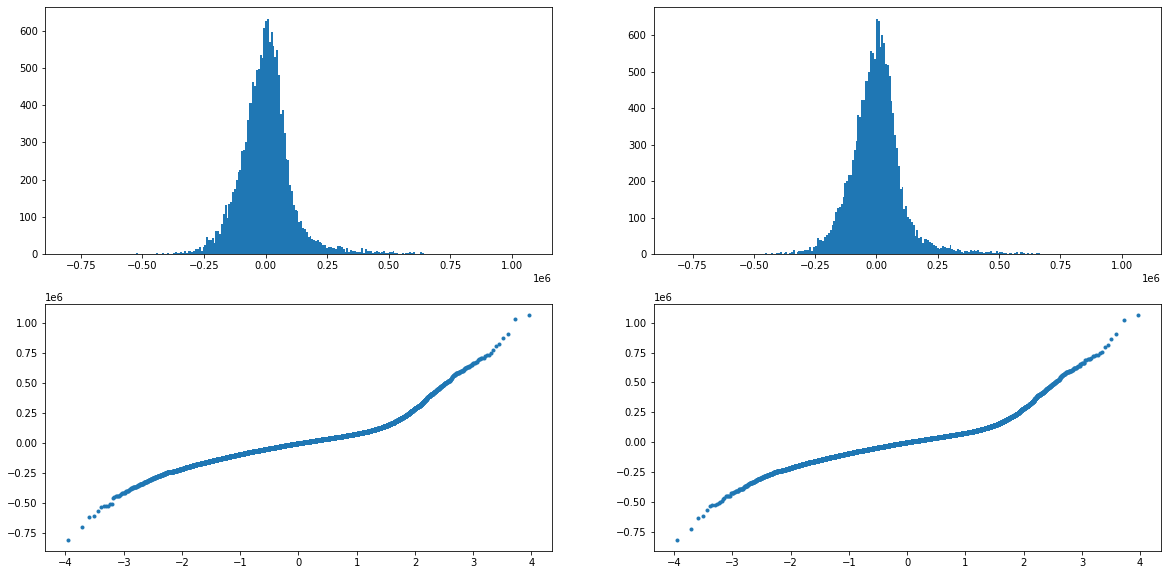

In [418]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

pos_total, res_total = probscale.plot_pos(residuals_total)
pos, res = probscale.plot_pos(residuals)
quantile = stats.norm.ppf(pos)

ax[0][0].hist(residuals, bins=250);
ax[0][1].hist(residuals_total, bins=250);
ax[1][0].scatter(quantile, res, marker='.');
ax[1][1].scatter(quantile, res_total, marker='.')

fig.show;
#plt.savefig('images/res.png', format='png', dpi=150)

Discussion:

- Systematic deviation: residuals accumulate outside the center of the bell curve at the slopes, with a slight ... to negative residuals. Ie larger residuals are more frequent than they were if completely random, and the model tends to overestimate price.

- The effect does not depend on the choice of a training set.

- It would be interesting to study how this effect depends on the construction of the model (choice of cutoffs, deletion of outliers, selection of variables etc)

#### Jarque-Bera and Kolmogorov-Smirnov tests:

In [419]:
print('Test of trained model: p(JB) =', stats.jarque_bera(residuals)[1], ' p(KS) = ', stats.kstest(residuals,'norm')[1])
print('Total data set: p(JB) = ', stats.jarque_bera(residuals_total)[1], ' p(KS) = ', stats.kstest(residuals_total,'norm')[1])

Test of trained model: p(JB) = 0.0  p(KS) =  0.0
Total data set: p(JB) =  0.0  p(KS) =  0.0
